In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

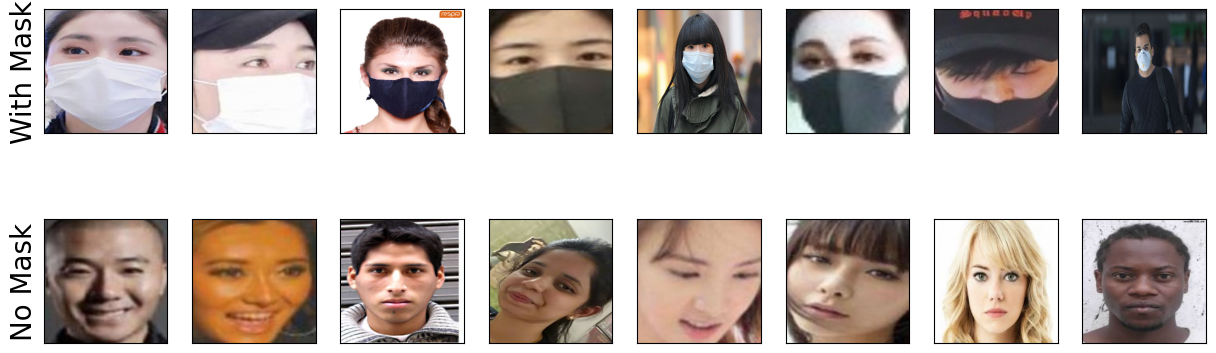

In [3]:
import os
import random
import matplotlib.pyplot as plt
import cv2

with_mask_dir = '/content/drive/MyDrive/colab/FaceMask/with_mask'
without_mask_dir = '/content/drive/MyDrive/colab/FaceMask/without_mask'

num_images = 8

random_with_mask_files = random.sample(os.listdir(with_mask_dir), num_images)
random_without_mask_files = random.sample(os.listdir(without_mask_dir), num_images)

plt.figure(figsize=(15, 5))
i = 0
for c in ["With Mask", "No Mask"]:
    path = with_mask_dir if c == "With Mask" else without_mask_dir
    image_files = random_with_mask_files if c == "With Mask" else random_without_mask_files
    for img in image_files:
        plt.subplot(2, num_images, i + 1)
        img_arr = plt.imread(os.path.join(path, img))
        img_arr = cv2.resize(img_arr, (227, 227))
        plt.imshow(img_arr)
        if i % num_images == 0:
            plt.ylabel(c, size=20)
        plt.xticks([])
        plt.yticks([])
        i += 1

plt.show()


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2


In [5]:

with_mask_dir = '/content/drive/MyDrive/colab/FaceMask/with_mask'
without_mask_dir = '/content/drive/MyDrive/colab/FaceMask/without_mask'

In [6]:
def load_and_preprocess_data(image_dir, target_size=(227, 227)):
    images = []
    labels = []
    for label, dir_name in enumerate([with_mask_dir, without_mask_dir]):
        for img_filename in os.listdir(dir_name):
            img_path = os.path.join(dir_name, img_filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [7]:
X_test, Y_test = load_and_preprocess_data(with_mask_dir, target_size=(227, 227))


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_test, Y_test, test_size=0.2)

In [9]:

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
from tensorflow import keras

input_shape = (227, 227, 3)
num_classes = 2
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))


model.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 227, 227, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 113, 113, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 113, 113, 128)     36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 113, 113, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.000000001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.02 ,patience=5, restore_best_weights=True)

In [13]:
batch_size = 128
epochs = 20

history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    validation_data=(X_val, Y_val),
                    epochs=epochs,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
24/24 [==============================] - 128s 4s/step - loss: 0.6981 - accuracy: 0.4873 - val_loss: 1.0430 - val_accuracy: 0.5007
Epoch 2/20
24/24 [==============================] - 52s 2s/step - loss: 0.6980 - accuracy: 0.4980 - val_loss: 1.0430 - val_accuracy: 0.5007
Epoch 3/20
24/24 [==============================] - 51s 2s/step - loss: 0.6980 - accuracy: 0.4870 - val_loss: 1.0428 - val_accuracy: 0.5007
Epoch 4/20
24/24 [==============================] - 52s 2s/step - loss: 0.6979 - accuracy: 0.5046 - val_loss: 1.0427 - val_accuracy: 0.5007
Epoch 5/20
24/24 [==============================] - 51s 2s/step - loss: 0.6977 - accuracy: 0.5124 - val_loss: 1.0426 - val_accuracy: 0.5007
Epoch 6/20
24/24 [==============================] - 53s 2s/step - loss: 0.6980 - accuracy: 0.4896 - val_loss: 1.0428 - val_accuracy: 0.5007


In [14]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_accuracy)

120/120 [==============================] - 14s 113ms/step - loss: 1.0406 - accuracy: 0.5004
Test accuracy: 0.5003913640975952


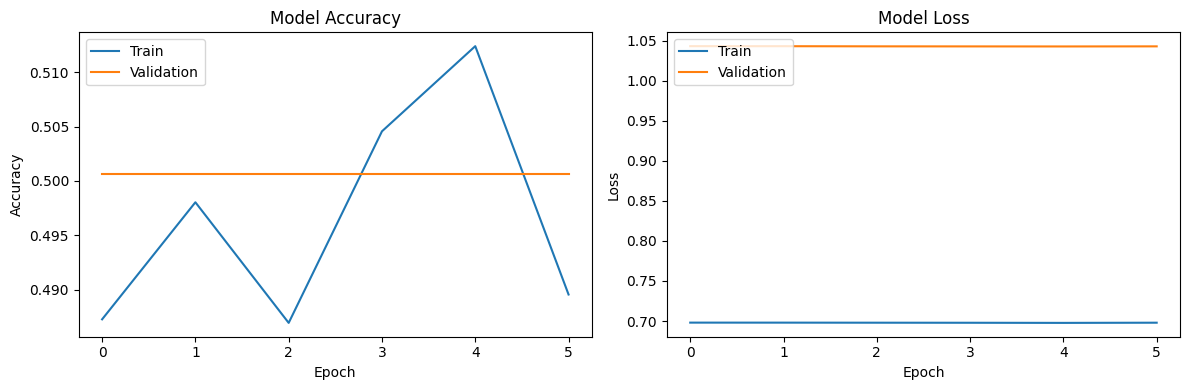

In [15]:
# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
model.save('saved_models/mask_detection_model.h5')


In [17]:
model = tf.keras.models.load_model('saved_models/mask_detection_model.h5')

In [25]:
def preprocess_image(image_path, target_size=(227, 227)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  # Normalize the image
    return img

In [26]:
class_labels = ['With Mask', 'Without Mask']

In [27]:
def detect_mask(image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]
    label = class_labels[predicted_class]
    return label, confidence


In [32]:
input_image_path = '/content/drive/MyDrive/colab/FaceMask/without_mask/Faceimg1,000.jpg'

In [33]:
label, confidence = detect_mask(input_image_path)
print(f"Prediction: {label} (Confidence: {confidence:.2f})")

1/1 [==============================] - 0s 32ms/step
Prediction: Without Mask (Confidence: 0.50)
